### Importing Python library

##### reference tutorial: https://mohammadimranhasan.com/digitise-geographic-features/

In [18]:
import os
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import measure
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
%matplotlib inline

### Importing Image

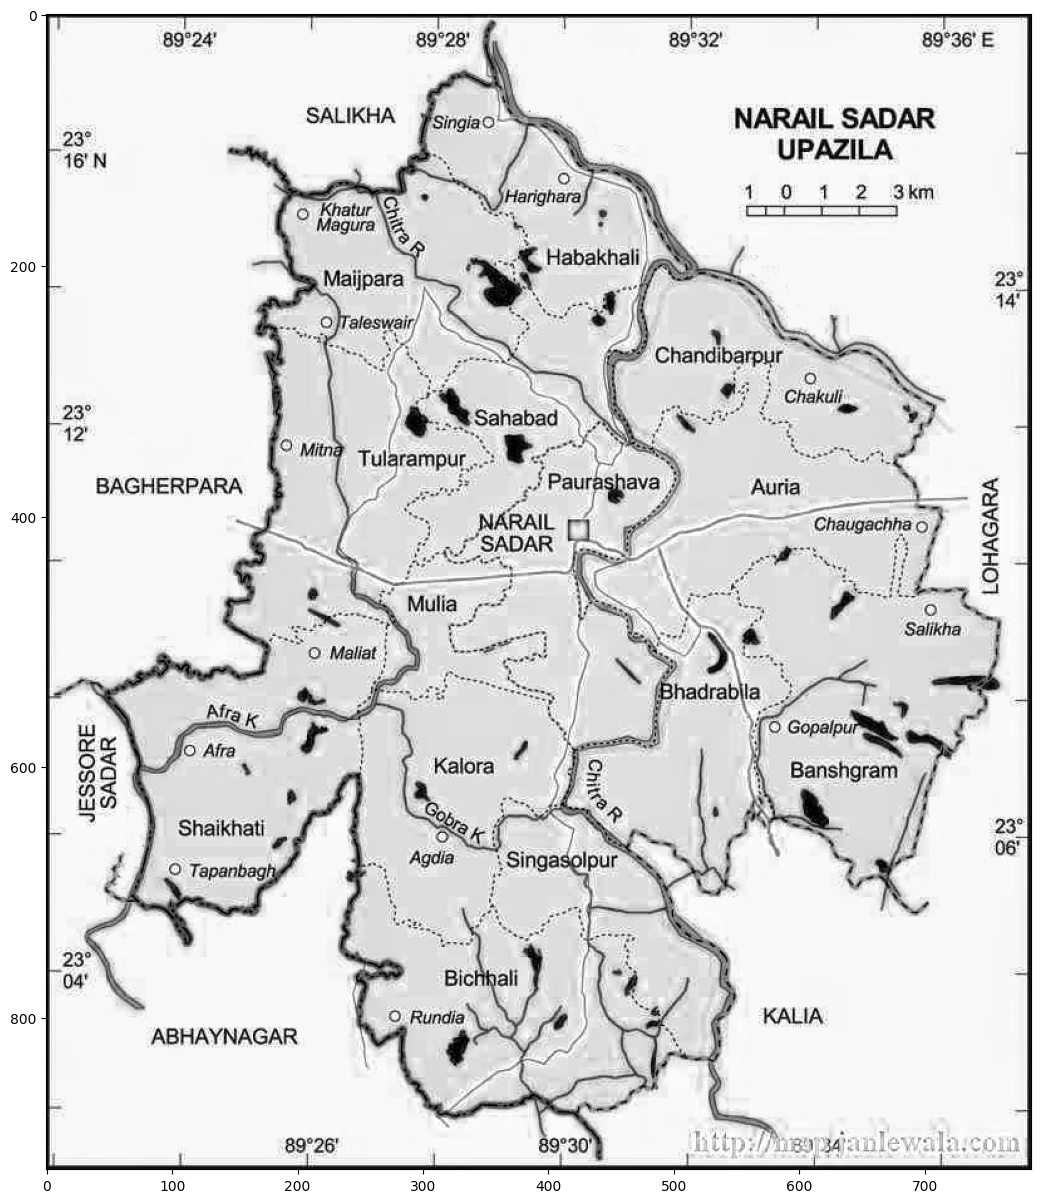

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace the URL with the local file path
file_path = r'D:\LEARNING\12. MSc\0. Project\2024_05_04_Code\Automated_Digitization\narail_sadar_text_removed.png'

# Load the image from the local file path
image = mpimg.imread(file_path)
test_image = image.copy()[:,:,0]

plt.figure(figsize=(15, 15))
plt.imshow(test_image, cmap='gray')
plt.show()


### Digitising by histogram and extract geographic features

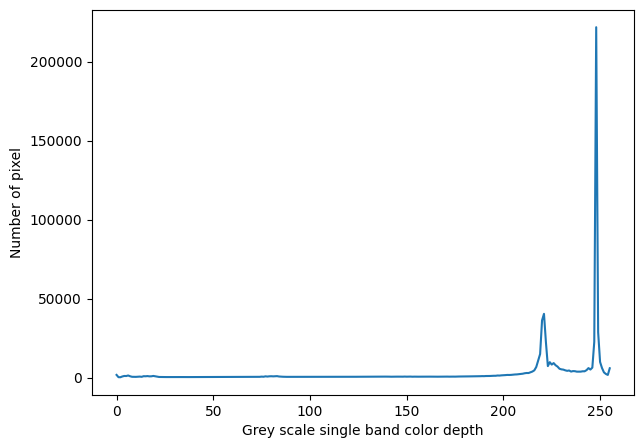

In [22]:
test_image = test_image*255
hist, bin_edge = np.histogram(test_image.ravel(), bins=256)
plt.figure(figsize=(7,5))
plt.plot(hist)
plt.ylabel('Number of pixel')
plt.xlabel('Grey scale single band color depth');

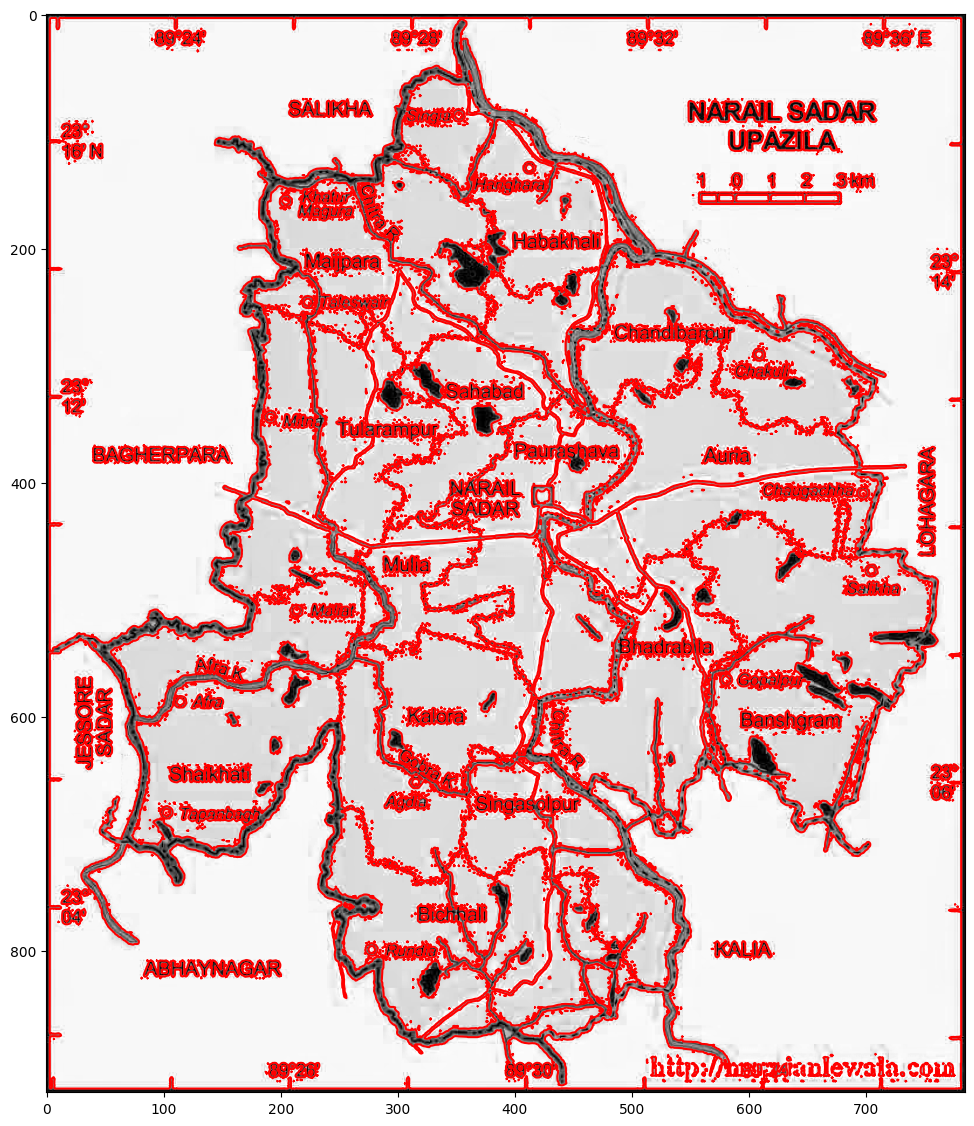

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Assuming 'test_image' is my binary image
contours = measure.find_contours(test_image, 197)

plt.figure(figsize=(14, 14))
plt.imshow(test_image, cmap='gray')

for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='r')

plt.show()

### Noise reduction

In [25]:
def filter_point(x, y,num_point, trial_xarr, trial_yarr):
    mask1 = np.ones(np.shape(trial_xarr), dtype=bool) 
    for i in range(len(trial_xarr)):
        sumangel = 0
        for j in range(num_point):
            x1, y1 = x[j], y[j]
            x2, y2 = x[j+1], y[j+1]
            a = ((x1-x2)**2+(y1-y2)**2)**0.5
            c = ((x1-trial_xarr[i])**2+(y1-trial_yarr[i])**2)**0.5
            b = ((x2-trial_xarr[i])**2+(y2-trial_yarr[i])**2)**0.5
            an_v = (b**2+c**2-a**2)/(2*b*c)
            if an_v<-1:
                an_v=-1
            elif an_v>1:
                an_v=1
            else:
                an_v=an_v
            angel = math.acos(an_v)
            sumangel+=angel
        if sumangel <6.2831852:
            mask1[i]=False
    xf = trial_xarr[mask1]
    yf = trial_yarr[mask1]
    return xf, yf

### Function for smoothing the polygon feature

In [26]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

### Application of the two functions together

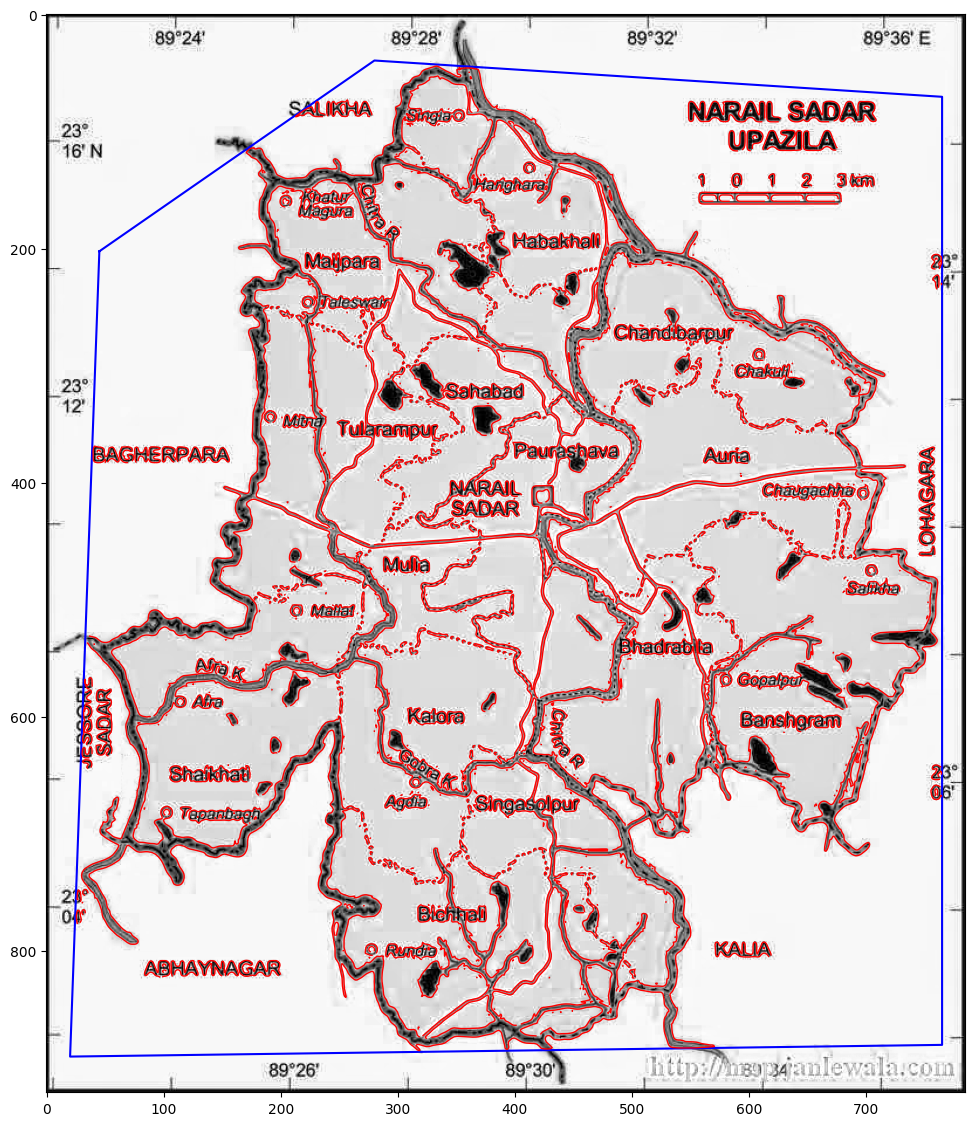

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import measure
import math

def filter_point(x, y, num_point, trial_xarr, trial_yarr):
    mask1 = np.ones(np.shape(trial_xarr), dtype=bool) 
    for i in range(len(trial_xarr)):
        sumangel = 0
        for j in range(num_point):
            x1, y1 = x[j], y[j]
            x2, y2 = x[j+1], y[j+1]
            a = ((x1-x2)**2+(y1-y2)**2)**0.5
            c = ((x1-trial_xarr[i])**2+(y1-trial_yarr[i])**2)**0.5
            b = ((x2-trial_xarr[i])**2+(y2-trial_yarr[i])**2)**0.5
            an_v = (b**2+c**2-a**2)/(2*b*c)
            if an_v < -1:
                an_v = -1
            elif an_v > 1:
                an_v = 1
            else:
                an_v = an_v
            angle = math.acos(an_v)
            sumangel += angle
        if sumangel < 6.2831852:
            mask1[i] = False
    xf = trial_xarr[mask1]
    yf = trial_yarr[mask1]
    return xf, yf

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Define your polygon points
x = [45, 280, 765, 765, 20, 45]
y = [202, 39, 70, 880, 890, 202]

# Assuming 'test_image' is your binary image
contours = measure.find_contours(test_image, 197)

# Filter noise points
filtered_contours = []
for contour in contours:
    filtered_contour = filter_point(x, y, len(x)-1, contour[:, 1], contour[:, 0])
    filtered_contours.append(filtered_contour)

# Apply moving average for smoothing
smoothed_contours = []
for filtered_contour in filtered_contours:
    smoothed_contour = np.column_stack((moving_average(filtered_contour[0], n=7), moving_average(filtered_contour[1], n=7)))
    smoothed_contours.append(smoothed_contour)

plt.figure(figsize=(14, 14))
plt.imshow(test_image, cmap='gray')

# Plot the original polygon
plt.plot(x, y, 'b-')

# Plot the smoothed polygon
for contour in smoothed_contours:
    plt.plot(contour[:, 0], contour[:, 1], lw=1, color='r')

plt.show()


### Indirect geo referencing

In [33]:
import plotly.io as pio

# Assuming 'test_image' is your image array
trace_image = go.Heatmap(z=test_image, colorscale='Greys')

layout = go.Layout(
    width=785,
    height=921,
    yaxis=dict(autorange='reversed')
)

fig = go.Figure(data=[trace_image], layout=layout)

# Save the plot as an HTML file
pio.write_html(fig, 'plot.html')



### Coordinate transfer to the feature

In [37]:
# Parameters for coordinate transfer
min_x = 2  # Every 98 pixels along x axis equals 2 minutes
min_y = 2  # Every 112 pixels along y axis equals 2 minutes
pix_x = 98  # Pixel interval along x axis
pix_y = 112  # Pixel interval along y axis
st_pix_x = 122  # X pixel index of 1st GCP
st_pix_y = 88  # Y pixel index of 1st GCP

# Calculate starting latitude and longitude based on the first GCP pixel indices
starting_x = 89 + (24 / 60) - ((st_pix_x * min_x) / 60 / pix_x)
starting_y = 23 + (16 / 60) + ((st_pix_y * min_y) / 60 / pix_y)

# Calculate multiplication factors for converting pixel increments to minutes
mult_factor_x = (min_x / 60) / pix_x
mult_factor_y = (min_y / 60) / pix_y

# Assuming 'test_image' is your binary image
contours = measure.find_contours(test_image, 197)

# Filter noise points
filtered_contours = []
for contour in contours:
    filtered_contour = filter_point(x, y, len(x)-1, contour[:, 1], contour[:, 0])
    filtered_contours.append(filtered_contour)

# Apply moving average for smoothing
smoothed_contours = []
for filtered_contour in filtered_contours:
    smoothed_contour = np.column_stack((moving_average(filtered_contour[0], n=7), moving_average(filtered_contour[1], n=7)))
    smoothed_contours.append(smoothed_contour)

# Extract the smoothed coordinates of the polygon
xf = smoothed_contours[0][:, 0]  # Assuming the first contour is the desired polygon
yf = smoothed_contours[0][:, 1]  # Assuming the first contour is the desired polygon

# Perform the coordinate transfer
x_ref = []
y_ref = []

for i in xf:
    x_ref.append(starting_x + (i * mult_factor_x))
for j in yf:
    y_ref.append(starting_y - (j * mult_factor_y))

### Converting polygon to shapefile

In [40]:
df = pd.DataFrame({'Long':x_ref,'Lat':y_ref})
df['Coordinates'] = list(zip(df.Long, df.Lat))
df['Coordinates'] = Polygon(df['Coordinates'])
crs = {'init': 'epsg:4326'}
Narail_upazila = gpd.GeoDataFrame(df, geometry='Coordinates', crs=crs)

c:\Users\DRK2\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



### Super imposing extracted shapefile on actual shapefile

In [44]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# Assuming 'x_ref' and 'y_ref' contain the coordinates of the polygon
df = pd.DataFrame({'Long': x_ref, 'Lat': y_ref})

# Combine longitude and latitude into a tuple representing the coordinates
df['Coordinates'] = list(zip(df.Long, df.Lat))

# Create a Polygon geometry from the coordinates
df['Coordinates'] = Polygon(df['Coordinates'])

# Define the coordinate reference system (CRS) as EPSG:4326 (WGS84)
crs = {'init': 'epsg:4326'}

# Create a GeoDataFrame with the geometry column representing the polygon
Narail_upazila = gpd.GeoDataFrame(df, geometry='Coordinates', crs=crs)


# Define the path for the shapefile store folder
folder_path = r'D:\LEARNING\12. MSc\0. Project\2024_05_04_Code\Automated_Digitization\shapefile'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save the GeoDataFrame as a shapefile in the specified folder
Narail_upazila.to_file(os.path.join(folder_path, "Narail_upazila.shp"))



c:\Users\DRK2\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

C:\Users\DRK2\AppData\Local\Temp\ipykernel_15876\175909520.py:30: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



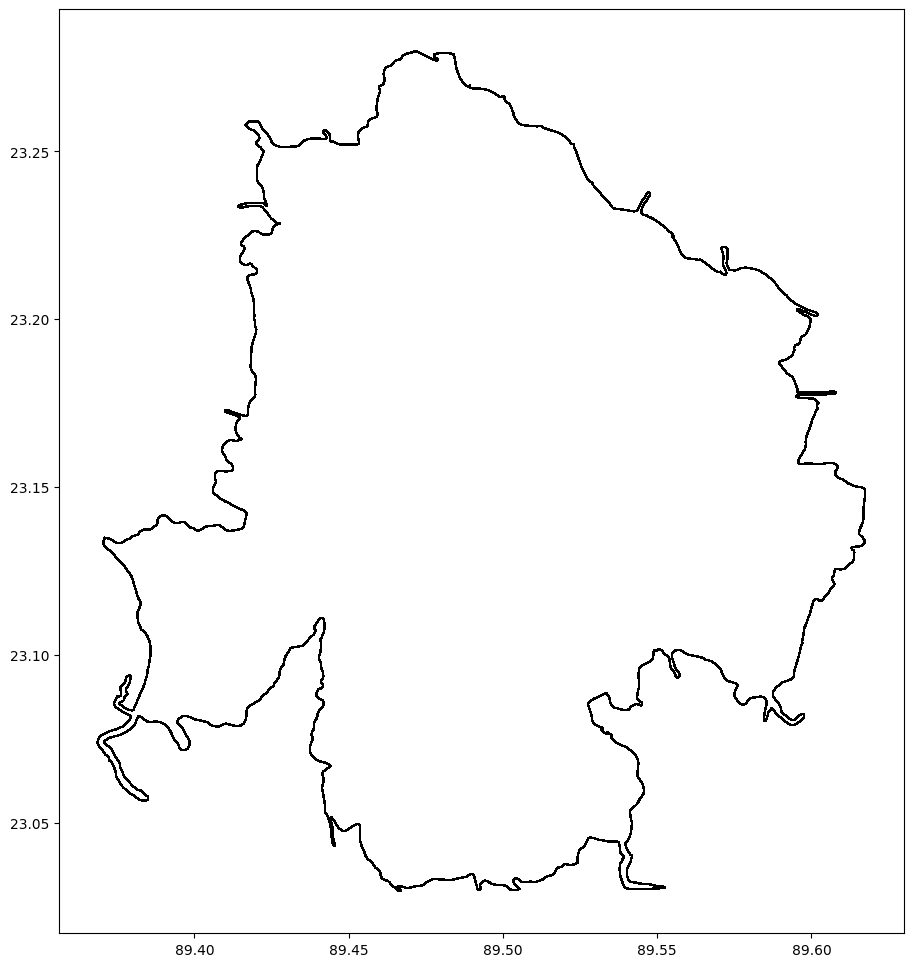

In [45]:
import geopandas as gpd

# Path to the saved shapefiles
shapefile_path = r'D:\LEARNING\12. MSc\0. Project\2024_05_04_Code\Automated_Digitization\shapefile\Narail_upazila.shp'

# Read the shapefile
Narail_upazila_saved = gpd.read_file(shapefile_path)

# Ploting the shapefile 
ax = Narail_upazila_saved.plot(figsize=(12, 12), facecolor='None', edgecolor='k')
plt.show()
